In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
import branca
import json
from shapely.geometry import Point
import fiona

In [25]:
gdb_path = '../data/raw/map_files/KEN_AdminBoundaries_working.gdb'

layer_names = ['adminUnitLookup', 'kenya_counties', 'kenya', 'admbndlALL', 'kenya_sub_counties', 'admbndpALL']
layers = dict(zip(fiona.listlayers(gdb_path), layer_names))

geo_dfs = dict()

for layer, name in layers.items():
    geo_dfs[name] = gpd.read_file(gdb_path, layer=layer)

for i in ['adminUnitLookup', 'admbndlALL', 'admbndpALL']:
    geo_dfs.pop(i)

geo_dfs['kenya_wards'] = gpd.read_file('../data/raw/map_files/Kenya_Wards/kenya_wards.shp')


def filter_geodf(geodf, admin_level, admin_names):
    return geodf[geodf[admin_level].str.contains('|'.join(admin_names if isinstance(admin_names, list) else [admin_names]))]

geo_dfs['narig_wards'] = filter_geodf(geo_dfs['kenya_wards'], 'ward', ['Kako', 'Mtito Andei', 'Tulimani', 'Thange'])

col_names = {'admin0Name_en': 'country',
             'admin1Name_en': 'county',
             'admin2Name_en': 'sub_county',
             'Shape_Length': 'perimeter',
             'Shape_Area': 'area',
             'subcounty': 'sub_county'}

for df in geo_dfs.values():
    df.rename(columns=col_names, inplace=True)

cols = ['country', 'county', 'sub_county', 'ward', 'perimeter', 'area', 'geometry']

for k, v in geo_dfs.items():
    v.drop(columns=[col for col in v.columns if col not in cols], inplace=True)
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].str.title().str.replace(' Sub County', '').str.replace(' Ward', '')
    df.to_file('../data/processed/geojson/{}.geojson'.format(k), driver='GeoJSON')

C:\Users\kisee\AppData\Local\Temp\ipykernel_18532\3301415530.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=col_names, inplace=True)
C:\Users\kisee\AppData\Local\Temp\ipykernel_18532\3301415530.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v.drop(columns=[col for col in v.columns if col not in cols], inplace=True)
C:\Users\kisee\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [26]:
survey_path = '../data/raw/NARIG_Survey.xlsx'
column_names_path = '../data/processed/json/column_names.json'

survey_df = pd.read_excel(survey_path, usecols='A:EG')
col_names = json.load(open(column_names_path, 'r'))

survey_df.rename(columns=col_names, inplace=True)

replace_map = {'Diasgree': 'Disagree',
               '6+': 6, 
               'Kako': 'Waia/Kako',
               'Mtito': 'Mtito Andei'}

ordinal_map = {'Strongly Agree': 5,
               'Agree': 4,
               'Neutral': 3,
               'Disagree': 2,
               'Strongly Disagree': 1}

survey_df.replace(replace_map, inplace=True)
survey_df.replace(ordinal_map, inplace=True)

survey_df['gender'] = survey_df['gender'].str.split().str[-1]
survey_df = survey_df.astype({'household_size': int})

survey_df['age'] = survey_df['age'].replace(0, np.nan)
survey_df['household_size'] = survey_df['household_size'].replace(6, np.nan)

sample_size_pre = survey_df['value_chain'].value_counts().to_frame()

orig_col_order = list(survey_df.columns)

value_chains = list(survey_df['value_chain'].unique())

narig_dfs = {vc: survey_df[survey_df['value_chain'] == vc].dropna(axis=1, how='all') for vc in value_chains}


def engineer_change_features(df):
    for col in df.columns:
        if col.endswith('_before') or col.endswith('_after'):
            base_col = col.rsplit('_', 1)[0]
            before_col = base_col + '_before'
            after_col = base_col + '_after'
            if before_col in df.columns and after_col in df.columns:
                change_col = base_col + '_change'
                df[change_col] = df[after_col] - df[before_col]
                change_col_index = max(df.columns.get_loc(before_col), df.columns.get_loc(after_col)) + 1
                change_col_data = df[change_col]
                df.drop(columns=[change_col], inplace=True)
                df.insert(change_col_index, change_col, change_col_data)
    return df

for k, v in narig_dfs.items():
    v.columns = v.columns.str.replace('_\d', '', regex=True)
    v.dropna(axis=0, inplace=True)
    v = engineer_change_features(v)
    
narig_dfs['Survey data'] = pd.concat(narig_dfs.values(), ignore_index=True)
narig_dfs['Survey data'] = narig_dfs['Survey data'][[col for col in orig_col_order if col in narig_dfs['Survey data'].columns]]

narig_dfs['Survey data'] = engineer_change_features(narig_dfs['Survey data'])

for k, v in narig_dfs.items():
    for col in v.select_dtypes('object').columns:
        v[col] = v[col].astype('category')
    display(k)
    display(v.info(), v.head())
    
    v.to_csv('../data/processed/csv/{}.csv'.format(k.replace(' ', '_')), index=False)

sample_size_post = narig_dfs['Survey data']['value_chain'].value_counts().to_frame()

sample_size = pd.concat([sample_size_pre, sample_size_post], axis=1)
sample_size.columns = ['preprocessing', 'postprocessing']
sample_size.loc['Survey data'] = sample_size.sum()
sample_size['pre_post_ratio'] = sample_size['postprocessing'] / sample_size['preprocessing']

display(sample_size)

'Tomato'

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 0 to 343
Data columns (total 64 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                33 non-null     category
 1   gender                              33 non-null     category
 2   age                                 33 non-null     float64 
 3   education                           33 non-null     category
 4   monthly_income                      33 non-null     int64   
 5   household_size                      33 non-null     float64 
 6   family_head                         33 non-null     category
 7   value_chain                         33 non-null     category
 8   vc_experience                       33 non-null     int64   
 9   project_skepticism                  33 non-null     int64   
 10  adequate_consultation               33 non-null     int64   
 11  project_acceptance                  33

None

,ward,gender,age,education,monthly_income,household_size,family_head,value_chain,vc_experience,project_skepticism,...,trained_post_harvest,adopted_post_harvest,trained_value_addition,adopted_value_addition,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
0,Tulimani,Male,64.0,Secondary,30000,3.0,Yes,Tomato,40,5,...,Yes,Yes,Yes,Yes,5,5,4,5,5,5
1,Tulimani,Male,67.0,Secondary,20000,4.0,Yes,Tomato,20,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5
2,Tulimani,Female,33.0,Primary,5000,3.0,No,Tomato,5,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5
4,Tulimani,Male,71.0,Secondary,10000,5.0,Yes,Tomato,5,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5
7,Tulimani,Female,63.0,Secondary,1000,1.0,No,Tomato,5,5,...,Yes,Yes,Yes,Yes,5,5,3,5,5,5


'Mango'

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 10 to 362
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                39 non-null     category
 1   gender                              39 non-null     category
 2   age                                 39 non-null     float64 
 3   education                           39 non-null     category
 4   monthly_income                      39 non-null     int64   
 5   household_size                      39 non-null     float64 
 6   family_head                         39 non-null     category
 7   value_chain                         39 non-null     category
 8   vc_experience                       39 non-null     int64   
 9   project_skepticism                  39 non-null     int64   
 10  adequate_consultation               39 non-null     int64   
 11  project_acceptance                  3

None

,ward,gender,age,education,monthly_income,household_size,family_head,value_chain,vc_experience,project_skepticism,...,adopted_soil_moisture,trained_post_harvest,trained_value_addition,adopted_value_addition,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
10,Thange,Male,57.0,Primary,1000,4.0,Yes,Mango,2,4,...,No,Yes,Yes,No,5,5,2,3,4,4
11,Thange,Female,49.0,Primary,500,4.0,Yes,Mango,27,4,...,Yes,Yes,Yes,Yes,4,4,3,4,4,4
12,Thange,Female,67.0,Primary,500,3.0,Yes,Mango,43,4,...,Yes,Yes,Yes,Yes,5,4,5,4,4,3
16,Thange,Female,43.0,Primary,1000,5.0,Yes,Mango,4,4,...,Yes,Yes,Yes,No,3,4,4,4,4,4
17,Thange,Female,51.0,Secondary,2000,1.0,No,Mango,8,4,...,Yes,Yes,Yes,Yes,5,5,4,4,4,4


'Green gram'

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 27 to 352
Data columns (total 64 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                47 non-null     category
 1   gender                              47 non-null     category
 2   age                                 47 non-null     float64 
 3   education                           47 non-null     category
 4   monthly_income                      47 non-null     int64   
 5   household_size                      47 non-null     float64 
 6   family_head                         47 non-null     category
 7   value_chain                         47 non-null     category
 8   vc_experience                       47 non-null     int64   
 9   project_skepticism                  47 non-null     int64   
 10  adequate_consultation               47 non-null     int64   
 11  project_acceptance                  4

None

,ward,gender,age,education,monthly_income,household_size,family_head,value_chain,vc_experience,project_skepticism,...,trained_post_harvest,adopted_post_harvest,trained_value_addition,adopted_value_addition,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
27,Thange,Male,70.0,Primary,500,5.0,Yes,Green gram,25,4,...,Yes,Yes,Yes,Yes,5,5,4,4,4,4
29,Thange,Female,60.0,Primary,1000,5.0,No,Green gram,3,4,...,Yes,Yes,Yes,Yes,4,5,4,5,4,4
30,Thange,Male,63.0,Secondary,3000,1.0,Yes,Green gram,20,4,...,Yes,Yes,Yes,Yes,4,5,4,4,4,4
31,Thange,Male,70.0,Secondary,12000,4.0,Yes,Green gram,7,4,...,Yes,Yes,Yes,Yes,4,5,4,4,4,4
33,Thange,Female,43.0,Secondary,1000,3.0,Yes,Green gram,5,4,...,Yes,Yes,Yes,Yes,4,5,3,4,4,5


'Indigenous chicken'

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, 47 to 293
Data columns (total 62 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                115 non-null    category
 1   gender                              115 non-null    category
 2   age                                 115 non-null    float64 
 3   education                           115 non-null    category
 4   monthly_income                      115 non-null    int64   
 5   household_size                      115 non-null    float64 
 6   family_head                         115 non-null    category
 7   value_chain                         115 non-null    category
 8   vc_experience                       115 non-null    int64   
 9   project_skepticism                  115 non-null    int64   
 10  adequate_consultation               115 non-null    int64   
 11  project_acceptance                  

None

,ward,gender,age,education,monthly_income,household_size,family_head,value_chain,vc_experience,project_skepticism,...,trained_vaccination,adopted_vaccination,trained_hygiene_management,adopted_hygiene_management,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
47,Tulimani,Male,74.0,Primary,1500,5.0,Yes,Indigenous chicken,5,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5
50,Tulimani,Female,71.0,Primary,2000,4.0,Yes,Indigenous chicken,5,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5
51,Tulimani,Male,67.0,Secondary,20000,4.0,Yes,Indigenous chicken,5,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5
54,Tulimani,Male,66.0,Secondary,3000,2.0,Yes,Indigenous chicken,5,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5
56,Tulimani,Female,80.0,Primary,500,1.0,No,Indigenous chicken,2,5,...,Yes,Yes,Yes,Yes,5,5,5,5,5,5


'Survey data'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 91 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ward                                234 non-null    category
 1   gender                              234 non-null    category
 2   age                                 234 non-null    float64 
 3   education                           234 non-null    category
 4   monthly_income                      234 non-null    int64   
 5   household_size                      234 non-null    float64 
 6   family_head                         234 non-null    category
 7   value_chain                         234 non-null    category
 8   vc_experience                       234 non-null    int64   
 9   project_skepticism                  234 non-null    int64   
 10  adequate_consultation               234 non-null    int64   
 11  project_acceptance              

None

,ward,gender,age,education,monthly_income,household_size,family_head,value_chain,vc_experience,project_skepticism,...,trained_vaccination,adopted_vaccination,trained_hygiene_management,adopted_hygiene_management,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
0,Tulimani,Male,64.0,Secondary,30000,3.0,Yes,Tomato,40,5,...,NaN,NaN,NaN,NaN,5,5,4,5,5,5
1,Tulimani,Male,67.0,Secondary,20000,4.0,Yes,Tomato,20,5,...,NaN,NaN,NaN,NaN,5,5,5,5,5,5
2,Tulimani,Female,33.0,Primary,5000,3.0,No,Tomato,5,5,...,NaN,NaN,NaN,NaN,5,5,5,5,5,5
3,Tulimani,Male,71.0,Secondary,10000,5.0,Yes,Tomato,5,5,...,NaN,NaN,NaN,NaN,5,5,5,5,5,5
4,Tulimani,Female,63.0,Secondary,1000,1.0,No,Tomato,5,5,...,NaN,NaN,NaN,NaN,5,5,3,5,5,5


,preprocessing,postprocessing,pre_post_ratio
value_chain,,,
Indigenous chicken,169,115,0.680473
Green gram,70,47,0.671429
Mango,63,39,0.619048
Tomato,61,33,0.540984
Survey data,363,234,0.644628


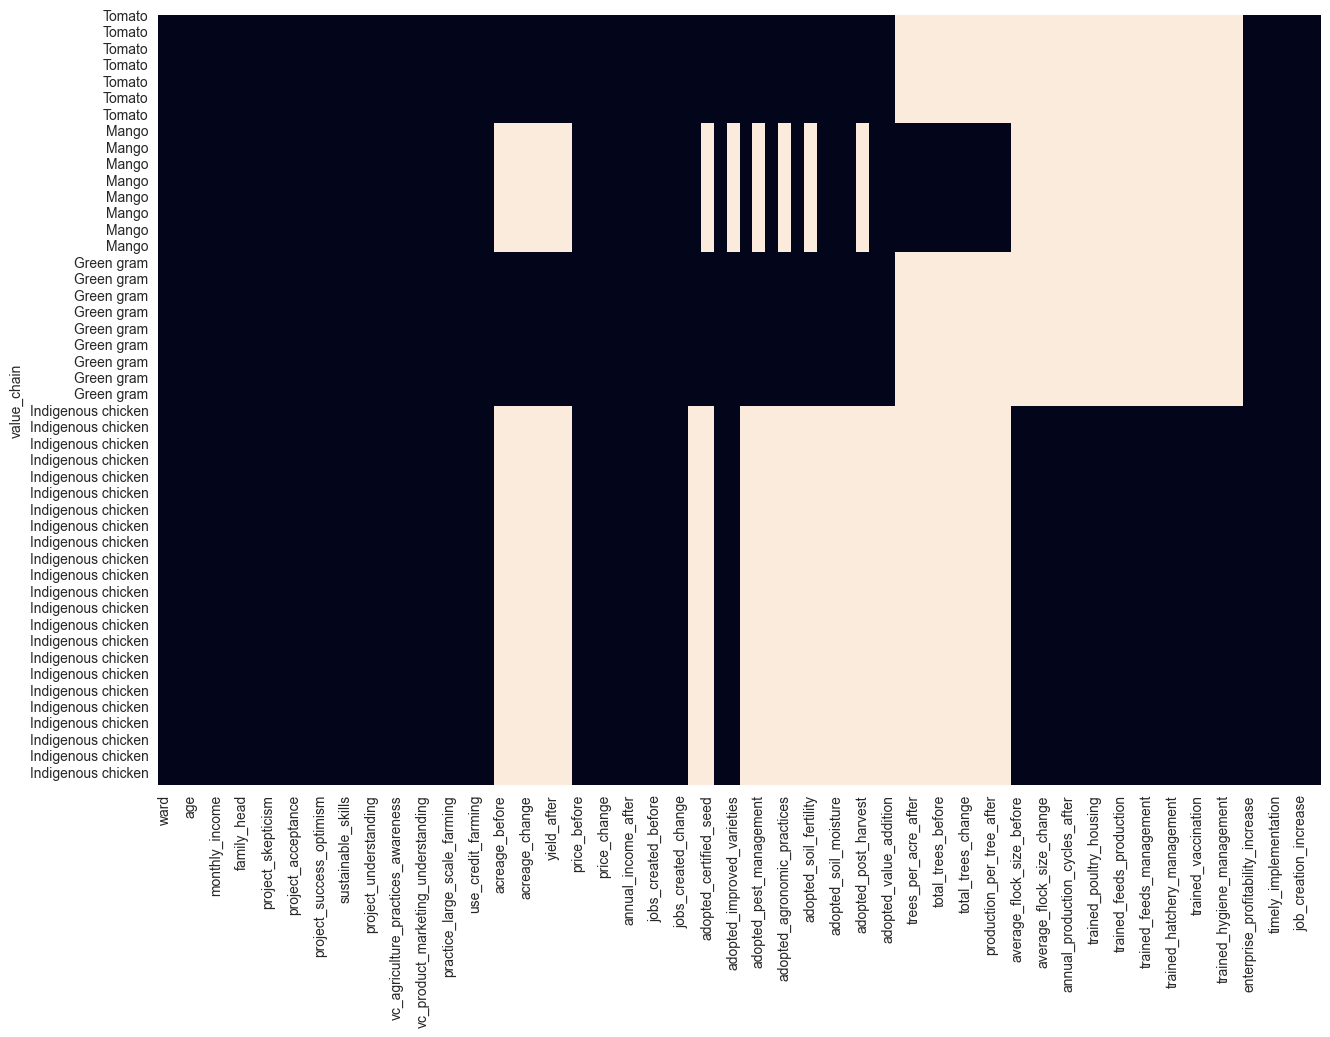

In [27]:
plt.figure(figsize=(15, 10))
sns.heatmap(narig_dfs['Survey data'].set_index('value_chain').isnull(), cbar=False)
plt.show()

In [30]:
narig_gpd = geo_dfs['narig_wards'].merge(narig_dfs['Survey data'], on='ward', how='right')

display(narig_gpd.info(), narig_gpd.head())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 94 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   county                              234 non-null    object  
 1   sub_county                          234 non-null    object  
 2   ward                                234 non-null    object  
 3   geometry                            234 non-null    geometry
 4   gender                              234 non-null    category
 5   age                                 234 non-null    float64 
 6   education                           234 non-null    category
 7   monthly_income                      234 non-null    int64   
 8   household_size                      234 non-null    float64 
 9   family_head                         234 non-null    category
 10  value_chain                         234 non-null    category
 11  vc_experience           

None

,county,sub_county,ward,geometry,gender,age,education,monthly_income,household_size,family_head,...,trained_vaccination,adopted_vaccination,trained_hygiene_management,adopted_hygiene_management,enterprise_profitability_increase,farm_productivity_increase,timely_implementation,new_income_streams,job_creation_increase,project_inclusivity
0,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,64.0,Secondary,30000,3.0,Yes,...,NaN,NaN,NaN,NaN,5,5,4,5,5,5
1,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,67.0,Secondary,20000,4.0,Yes,...,NaN,NaN,NaN,NaN,5,5,5,5,5,5
2,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,33.0,Primary,5000,3.0,No,...,NaN,NaN,NaN,NaN,5,5,5,5,5,5
3,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Male,71.0,Secondary,10000,5.0,Yes,...,NaN,NaN,NaN,NaN,5,5,5,5,5,5
4,Makueni,Mbooni,Tulimani,"POLYGON ((37.38407 -1.52204, 37.38428 -1.52226...",Female,63.0,Secondary,1000,1.0,No,...,NaN,NaN,NaN,NaN,5,5,3,5,5,5


geopandas.geodataframe.GeoDataFrame